In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [259]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [260]:
data = pd.read_csv('data/PJM_Load_hourly.csv')

In [261]:
df = data.copy()
df.head()

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


In [262]:
df.shape

(32896, 2)

In [263]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJM Load'}, xlabel='Datetime'>

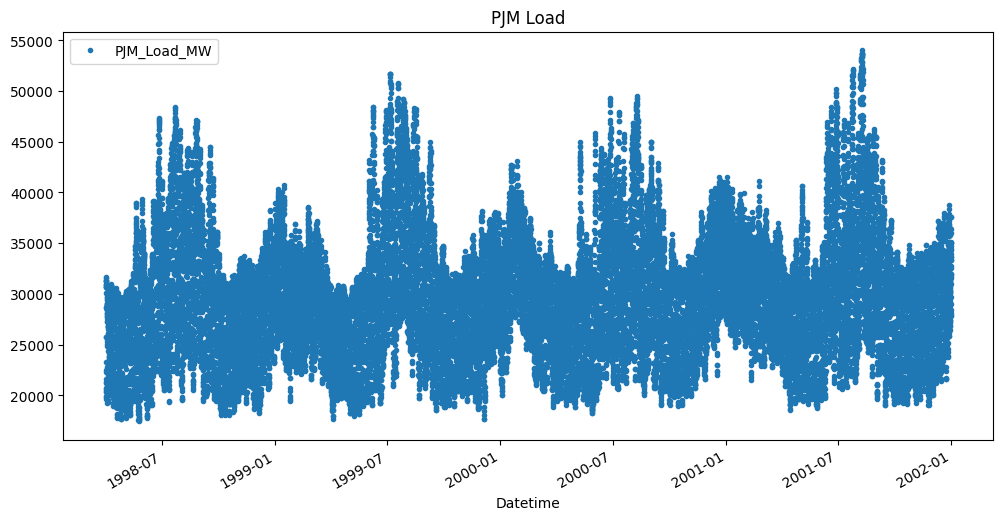

In [264]:
df.plot(style='.', figsize=(12,6), title='PJM Load')

### Cross-Validation for Time-Series

In [265]:
tss = TimeSeriesSplit(n_splits=3, test_size=12 * 365, gap=24)
df = df.sort_index()

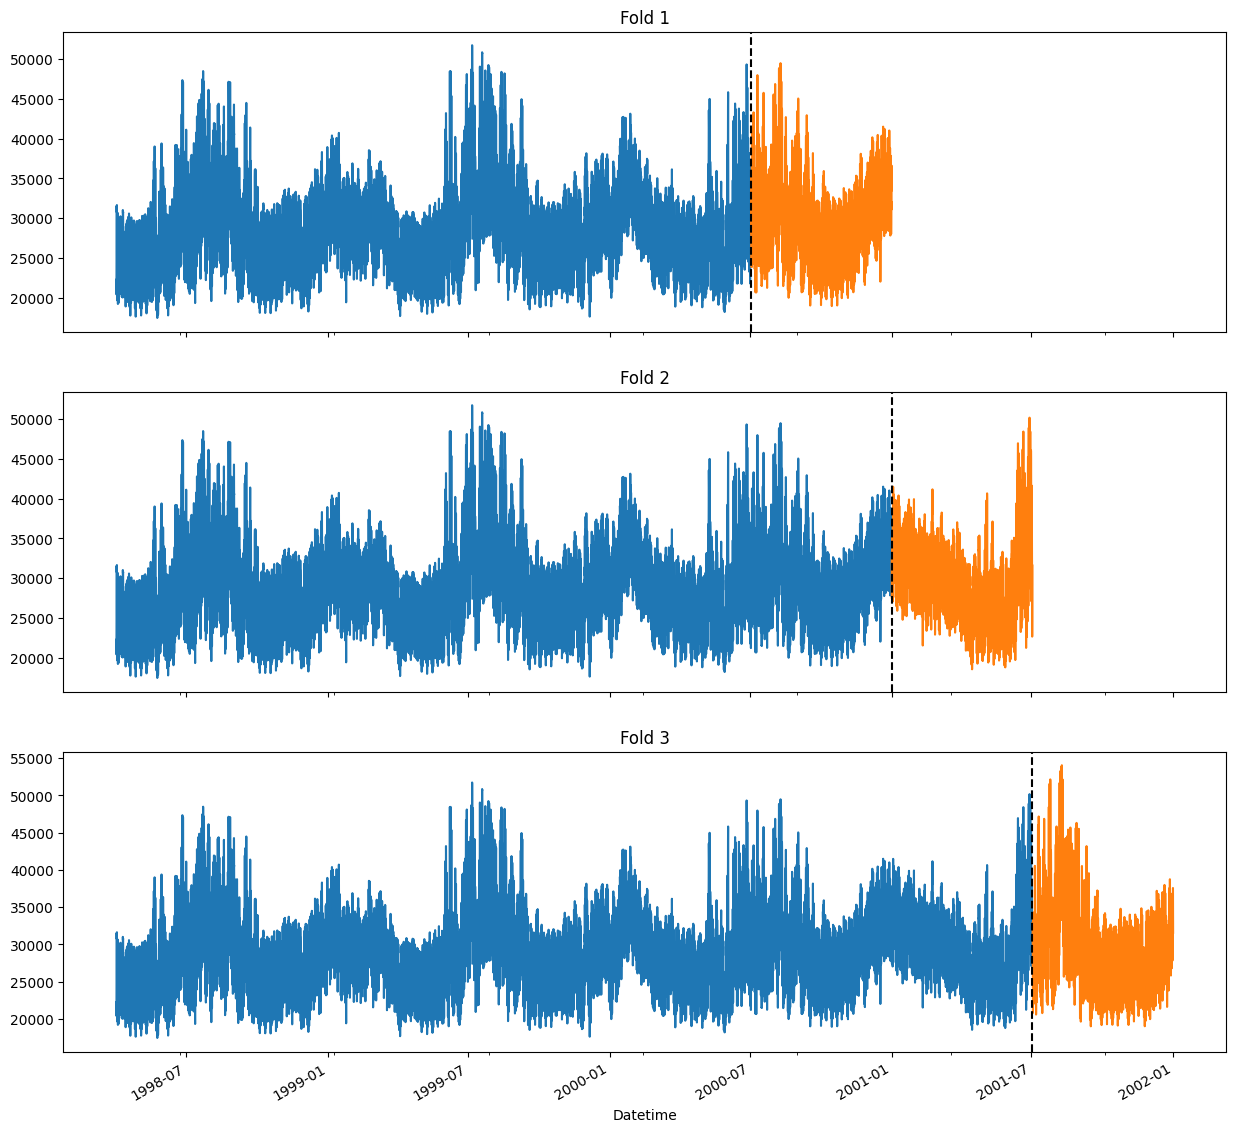

In [266]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJM_Load_MW'].plot(ax=axs[fold], label='Train', title=f'Fold {fold + 1}')
    test['PJM_Load_MW'].plot(ax=axs[fold], label='Test')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

In [267]:
## date based features 

def compute_date_features(df: pd.DataFrame) -> pd.DataFrame: 
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [268]:
## lag features 
target_map = df['PJM_Load_MW'].to_dict()

In [269]:
def add_lags(df: pd.DataFrame, map: dict) -> pd.DataFrame:
    df = df.copy()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    return df

In [270]:
df = compute_date_features(df)
df = add_lags(df, target_map)
df = df.dropna()
df

,PJM_Load_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2
Datetime,,,,,,,,,,,
2000-03-29 01:00:00,23391.0,1,2,1,3,2000,89,29,13,22625.0,22259.0
2000-03-29 02:00:00,22329.0,2,2,1,3,2000,89,29,13,21875.0,21244.0
2000-03-29 03:00:00,22190.0,3,2,1,3,2000,89,29,13,21778.0,20651.0
2000-03-29 04:00:00,22093.0,4,2,1,3,2000,89,29,13,21749.0,20421.0
2000-03-29 05:00:00,22703.0,5,2,1,3,2000,89,29,13,22321.0,20713.0
...,...,...,...,...,...,...,...,...,...,...,...
2001-12-31 20:00:00,36392.0,20,0,4,12,2001,365,31,1,35209.0,32565.0
2001-12-31 21:00:00,35082.0,21,0,4,12,2001,365,31,1,34791.0,31719.0
2001-12-31 22:00:00,33890.0,22,0,4,12,2001,365,31,1,33669.0,29811.0


### Training Loop

In [271]:
tss = TimeSeriesSplit(n_splits=3, test_size=12 * 365, gap=24)
df = df.sort_index() 

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2']
TARGET = 'PJM_Load_MW'

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    #print(train.columns)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg_cv = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=3,
        learning_rate=0.01,
        booster='gbtree',
        early_stopping_rounds=50,
        n_jobs=-1,              
        random_state=42,
        tree_method='hist' 
    )

    reg_cv.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=100
    )

    y_pred = reg_cv.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:5849.92780	validation_1-rmse:5838.99745
[100]	validation_0-rmse:3463.62955	validation_1-rmse:3747.60666
[165]	validation_0-rmse:2845.50360	validation_1-rmse:3840.62481
[0]	validation_0-rmse:5744.51380	validation_1-rmse:5245.76904
[100]	validation_0-rmse:3556.68186	validation_1-rmse:3369.14595
[200]	validation_0-rmse:2929.92649	validation_1-rmse:2992.07919
[295]	validation_0-rmse:2688.85899	validation_1-rmse:2973.35164
[0]	validation_0-rmse:5543.68610	validation_1-rmse:6378.29421
[100]	validation_0-rmse:3469.24348	validation_1-rmse:4419.71788
[200]	validation_0-rmse:2876.16873	validation_1-rmse:4029.27320
[300]	validation_0-rmse:2652.93421	validation_1-rmse:3954.62103
[382]	validation_0-rmse:2504.11716	validation_1-rmse:3940.10966


In [272]:
print(np.mean(scores))

3545.863787024276


In [281]:
params = reg_cv.get_params()
best_iter = reg_cv.best_iteration
params['n_estimators'] = best_iter

### Forecasting 

In [282]:
## train on all data 
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2']
TARGET = 'PJM_Load_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(
    **params
)

reg.fit(
    X_all, y_all, 
    eval_set=[(X_all, y_all)], 
    verbose=100
)

[0]	validation_0-rmse:5793.32241
[100]	validation_0-rmse:3705.73257
[200]	validation_0-rmse:3141.73284
[300]	validation_0-rmse:2922.59852
[331]	validation_0-rmse:2875.00951


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'gbtree'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabet

In [283]:
df.index.max()

Timestamp('2002-01-01 00:00:00')

In [284]:
future = pd.date_range('2002-01-01 00:00:00', '2003-01-01 00:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_full = pd.concat([df, future_df])
df_full = compute_date_features(df_full)
df_full = add_lags(df_full, target_map)
df_full

,PJM_Load_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture
2000-03-29 01:00:00,23391.0,1,2,1,3,2000,89,29,13,22625.0,22259.0,False
2000-03-29 02:00:00,22329.0,2,2,1,3,2000,89,29,13,21875.0,21244.0,False
2000-03-29 03:00:00,22190.0,3,2,1,3,2000,89,29,13,21778.0,20651.0,False
2000-03-29 04:00:00,22093.0,4,2,1,3,2000,89,29,13,21749.0,20421.0,False
2000-03-29 05:00:00,22703.0,5,2,1,3,2000,89,29,13,22321.0,20713.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-31 20:00:00,NaN,20,1,4,12,2002,365,31,1,NaN,41064.0,True
2002-12-31 21:00:00,NaN,21,1,4,12,2002,365,31,1,NaN,40445.0,True
2002-12-31 22:00:00,NaN,22,1,4,12,2002,365,31,1,NaN,39092.0,True
2002-12-31 23:00:00,NaN,23,1,4,12,2002,365,31,1,NaN,36242.0,True


In [285]:
future_w_features = df_full.query('isFuture').copy()
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

<Axes: >

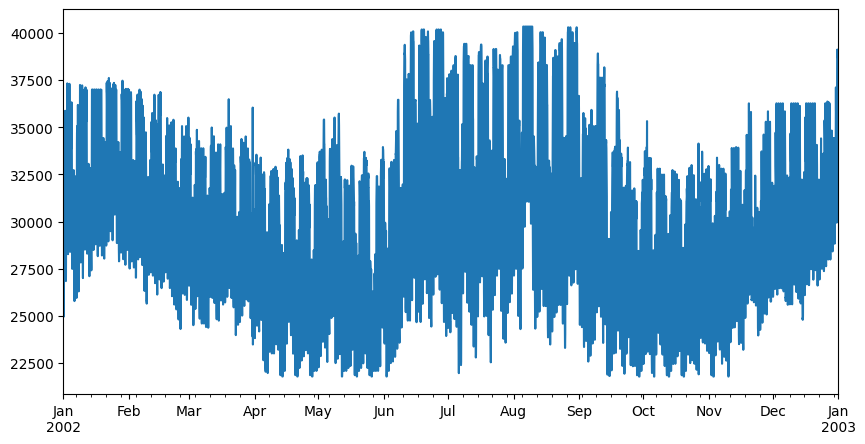

In [286]:
future_w_features['pred'].plot(
    figsize=(10,5)
)

In [287]:
plot_df = pd.concat([df, future_w_features])
plot_df

,PJM_Load_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture,pred
2000-03-29 01:00:00,23391.0,1,2,1,3,2000,89,29,13,22625.0,22259.0,False,NaN
2000-03-29 02:00:00,22329.0,2,2,1,3,2000,89,29,13,21875.0,21244.0,False,NaN
2000-03-29 03:00:00,22190.0,3,2,1,3,2000,89,29,13,21778.0,20651.0,False,NaN
2000-03-29 04:00:00,22093.0,4,2,1,3,2000,89,29,13,21749.0,20421.0,False,NaN
2000-03-29 05:00:00,22703.0,5,2,1,3,2000,89,29,13,22321.0,20713.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-31 20:00:00,NaN,20,1,4,12,2002,365,31,1,NaN,41064.0,True,39057.437500
2002-12-31 21:00:00,NaN,21,1,4,12,2002,365,31,1,NaN,40445.0,True,39057.437500
2002-12-31 22:00:00,NaN,22,1,4,12,2002,365,31,1,NaN,39092.0,True,39057.437500
2002-12-31 23:00:00,NaN,23,1,4,12,2002,365,31,1,NaN,36242.0,True,38693.738281


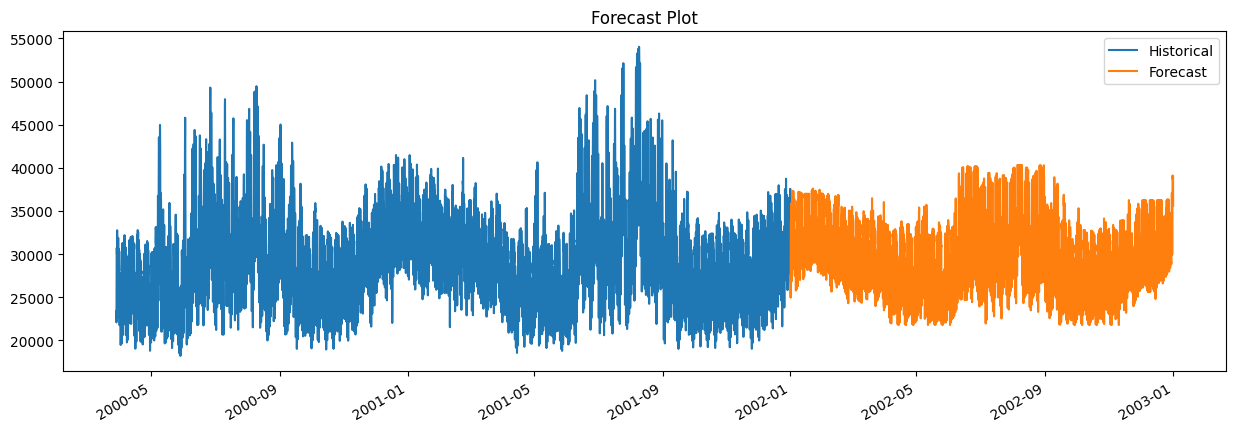

In [288]:
plot_df['PJM_Load_MW'].plot(figsize=(15,5), label='Historical', title=f'Forecast Plot')
plot_df['pred'].plot(label='Forecast')
plt.legend()
axs[fold].axvline(test.index.min(), color='black', ls='--')